In [1]:
import numpy as np
import pandas as pd
import json
import glob2
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
KEYS = ["A", "B", "C"]

## Data Paths

In [3]:
user_data_path = "data/study/user_data.csv"

response_data_paths = {}
for KEY in KEYS:
    response_data_paths[KEY] = {}
    for set_i in range(1, 3):
        response_data_paths[KEY]["{}{}".format(KEY, set_i)] = "data/study/response_data_{}{}.csv".format(KEY, set_i)

response_data_paths

{'A': {'A1': 'data/study/response_data_A1.csv',
  'A2': 'data/study/response_data_A2.csv'},
 'B': {'B1': 'data/study/response_data_B1.csv',
  'B2': 'data/study/response_data_B2.csv'},
 'C': {'C1': 'data/study/response_data_C1.csv',
  'C2': 'data/study/response_data_C2.csv'}}

# Response Dataframes

In [4]:
def replace_image_names(df):
    new_image_names = []
    for index, row in df.iterrows():
        row_breed_key = row["breed_key"]
        row_image_name = row["image_name"]
        row_breed_key = row_breed_key.strip().split("\n")
        row_breed_dict = { ele.split(":")[0].strip() : ele.split(":")[1].strip() for ele in row_breed_key}

        if "dog_A" in row_image_name:
            new_image_name = row_image_name.replace("dog_A", row_breed_dict["dog_A"])
        else:
            new_image_name = row_image_name.replace("dog_B", row_breed_dict["dog_B"])

        new_image_names.append(new_image_name)
    df["image_name"] = new_image_names

In [5]:
def find_invalid_users(df, verbose=False):
    user_IDs = set(df["user_id"])

    invalid_users = {}
    valid_user_ids = []
    for user_id in user_IDs:

        user_is_valid = True
        fail_reasons = []
        user_df = df[df["user_id"] == user_id]
    
        
       
        # CHECK NUMBER OF USER ENTRIES! Ensure 103
        # ========================================================
        num_user_entries = len(user_df)

        if num_user_entries < 103:
            fail_reason = "User {} does not have 103 entries - they have {}.".format(user_id, num_user_entries)
            fail_reasons.append(fail_reason)
            user_is_valid = False

        elif num_user_entries == 206:
            fail_reason = "User {} has 206 entries! Readjusting dataframe.".format(user_id)

            unique_sets = set(user_df["Dataset"])
            if unique_sets == 2:
                keep_set = datasets[np.random.randint(2)]
                user_df = user_df[user_df["Dataset"] == keep_set]
            else:
                user_df = user_df[:103]
        # ========================================================

        # CHECK THAT USERS DID NOT ENTER ONLY 1 ANSWER: e.g., all B's
        # ========================================================
        user_responses = user_df["user_response"]
        unique_responses = set(user_responses)

        if len(unique_responses) == 1:
            fail_reason = "User {} only entered {}'s".format(user_id, list(unique_responses)[0])
            fail_reasons.append(fail_reason)
            user_is_valid = False
        # ========================================================

        # CHECK THAT USERS PASSED ATTENTION CHECKS
        # ========================================================
        attention_check_threshold = 2
        attention_check_correct_responses = user_df[user_df["image_name"].str.contains('attention_check')]["user_correct"]
        attention_checks_passed = len(np.where(attention_check_correct_responses == True)[0])
        if attention_checks_passed < attention_check_threshold:
            fail_reason = "User {} only passed {}/4 attention checks!".format(user_id, attention_checks_passed)
            fail_reasons.append(fail_reason)
            user_is_valid = False
        # ========================================================

        if not user_is_valid:
            invalid_users[user_id] = {"reasons" : fail_reasons}
        else:
            valid_user_ids.append(user_id)

    invalid_user_ids = invalid_users.keys()

    num_total_users = len(user_IDs)
    
    if verbose:
        print("Total users: {}".format(num_total_users))

        print("\n")

        print("Invalid Users")
        print("-------------")
        for user_i, (invalid_user_id, val) in enumerate(invalid_users.items(), 1):
            print("\t{}. User {} -- Reasons: {}".format(user_i, invalid_user_id, val["reasons"][0]))

        print("\n")

        print("Valid Users")
        print("-----------")
        for valid_i, valid_user_id in enumerate(valid_user_ids):
            print("\t{:2.0f}. User {}".format(valid_i, valid_user_id))
    
    
    
    drop_indices = []
    for i, row_i in df.iterrows():
        if row_i["user_id"] in invalid_users.keys():
            drop_indices.append(i)
            
    valid_users_df = df.drop(df.index[drop_indices])
        
        

    return valid_users_df, invalid_users

In [6]:
response_data_header = ["user_id", "question_number", "question", "breed_key", "image_name", "user_response", "user_correct", "response_time"]

data_dfs = {}
invalid_users_dict = {}
for set_i, subsets in response_data_paths.items():
    
    subset_dfs = []
    for subset_i, subset_path in subsets.items():
        df = pd.read_csv(subset_path, header=None)
        df.columns = response_data_header
        subset_dfs.append(df)
        
    concat_df = pd.concat(subset_dfs, axis=0)
    cleaned_df = concat_df.drop("question", axis=1)
    
    replace_image_names(cleaned_df)
    
    valid_users_df, invalid_users = find_invalid_users(cleaned_df)
    
    
    data_dfs[set_i] = valid_users_df
    invalid_users_dict[set_i] = invalid_users
data_dfs["A"]

user_id  question_number  \
728        34                0   
729        34                1   
730        34                2   
731        34                3   
732        34                4   
733        34                5   
734        34                6   
735        34                7   
736        34                8   
737        34                9   
738        34               10   
739        34               11   
740        34               12   
741        34               13   
742        34               14   
743        34               15   
744        34               16   
745        34               17   
746        34               18   
747        34               19   
748        34               20   
749        34               21   
750        34               22   
751        34               23   
752        34               24   
753        34               25   
754        34               26   
755        34               27   
756        34               28   
757        34               29   
...       ...              ...   
2154       64               74   
2155       64               75   
2156       64               76   
2157       64               77   
2158       64               78   
2159       64               79   
2160       64               80   
2161       64               81   
2162       64               82   
2163       64               83   
2164       64               84   
2165       64               85   
2166       64               86   
2167       64               87   
2168       64               88   
2169       64               89   
2170       64               90   
2171       64               91   
2172       64               92   
2173       64               93   
2174       64               94   
2175       64               95   
2176       64               96   
2177       64               97   
2178       64               98   
2179       64               99   
2180       64              100   
2181       64              101   
2182       64              102   
2183       64              103   

                                              breed_key  \
728   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
729   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
730   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
731   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
732   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
733   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
734   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
735   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
736   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
737   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
738   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
739   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
740   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
741   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
742   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
743   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
744   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
745   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
746   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
747   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
748   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
749   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
750   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
751   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
752   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
753   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
754   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
755   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
756   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
757   dog_A : basset_hound\r\ndog_B : saint_bernard\r\n   
...                                                 ...   
2154  dog

## Invalid Users:

In [7]:
invalid_count = 0
for key, val in invalid_users_dict.items():
    invalid_count += len(val.keys()) 
invalid_count

40

In [8]:
invalid_users_dict

{'A': {3: {'reasons': ['User 3 only passed 0/4 attention checks!']},
  7: {'reasons': ['User 7 only passed 0/4 attention checks!']},
  8: {'reasons': ['User 8 only passed 0/4 attention checks!']},
  9: {'reasons': ['User 9 only passed 1/4 attention checks!']},
  17: {'reasons': ['User 17 only passed 0/4 attention checks!']},
  37: {'reasons': ['User 37 only passed 0/4 attention checks!']},
  48: {'reasons': ['User 48 only passed 0/4 attention checks!']},
  52: {'reasons': ['User 52 only passed 0/4 attention checks!']},
  53: {'reasons': ['User 53 only passed 0/4 attention checks!']},
  57: {'reasons': ['User 57 only passed 0/4 attention checks!']},
  66: {'reasons': ['User 66 only passed 0/4 attention checks!']}},
 'B': {70: {'reasons': ['User 70 only passed 1/4 attention checks!']},
  83: {'reasons': ['User 83 only passed 1/4 attention checks!']},
  89: {'reasons': ['User 89 only passed 1/4 attention checks!']},
  113: {'reasons': ['User 113 only passed 0/4 attention checks!']},
  115

## Distribution of Confidence Per Set

In [9]:
all_image_data = {}
for set_i, data_df in data_dfs.items():
    img_count = data_df.groupby("image_name")["user_correct"].count()
    img_correct = data_df.groupby("image_name")["user_correct"].sum()
    
    all_image_data[set_i] = []
    
    image_list = list(set(data_df["image_name"]))
    
    for img_name in image_list:
        
        if "attention" in img_name:
            continue
            
        img_df = data_df[data_df["image_name"]==img_name]
        
        breed_key = list(set(img_df["breed_key"]))[0]
        breed_key = breed_key.split("\n")
        breed_key = {breed.split(" : ")[0].strip() : breed.split(" : ")[1].strip() for breed in breed_key if breed != ""}
        
        actual_label = img_name.split("/")[-1].split("__")[0]
    
        # Confidence and Majority Label
        # ======================================================================
        user_responses = img_df["user_response"].value_counts()
        try:
            A_count = user_responses["A"]
            B_count = user_responses["B"]
            total_count = A_count + B_count
            
            if A_count >= B_count:
                majority_label = breed_key["dog_A"]
                img_confidence = A_count / float(total_count)
            else:
                majority_label = breed_key["dog_B"]
                img_confidence = B_count / float(total_count)
        except:
            if "A" in user_responses:
                img_confidence = 1.0
                majority_label = breed_key["dog_A"]
            else:
                img_confidence = 1.0
                majority_label = breed_key["dog_B"]
        # ======================================================================
        
        
        # Correctness
        # ======================================================================
        user_correctness = img_df["user_correct"].value_counts()
        
        try:
            user_correct_count = user_correctness[True]
            user_incorrect_count = user_correctness[False]
            total_count = float(user_correct_count + user_incorrect_count)
            img_correctness = user_correct_count / total_count
        except:
            if True in user_correctness:
                img_correctness = 1.0
            else:
                img_correctness = 0.0
        # ======================================================================         
        
        
        img_data = {
            "img_name" : img_name,
            "majority_label" : majority_label,
            "actual_label" : actual_label,
            "img_confidence" : img_confidence,
            "img_correctness" : img_correctness
        }
        
        all_image_data[set_i].append(img_data)
      
    

### Plot Distribution

In [151]:
def plot_image_distributions(data, subplots=(3,1), figsize=(8,4), histogram=False, bins=10):
    colors = ["#6baed6", "#6baed6", "#6baed6"]
    fig, ax = plt.subplots(subplots[0], subplots[1], figsize = figsize, dpi=100)
    
    
    ordered_plot_data = [(key, data[key]) for key in ["A", "B", "C"]]
    for i, (dataset, vals) in enumerate(ordered_plot_data):
        df = vals["df"]
        confidence_order = vals["confidence_order"]
        x_median = np.median(df["confidence"])
        lower_conf_count = len(np.where(df["confidence"] <= x_median)[0])
        higher_conf_count = len(np.where(df["confidence"] > x_median)[0])
        print("lower_conf_count: {}".format(lower_conf_count))
        print("higher_conf_count: {}".format(higher_conf_count))
        print("Set median: {}".format(x_median))
        y_median = 1
        if histogram:
            sns.distplot(df["confidence"], ax=ax[i], bins=bins)
            ax[i].set_title("Set {}".format(dataset))
            ax[i].set_xlabel("Confidence")
            ax[i].vlines(x_median, 0, y_median, 'r')
        else:
            sns.barplot(x="img_name", y="confidence", data=df, order=confidence_order, ax=ax[i], color=colors[i])
            ax[i].set_title("Set {}".format(dataset))
            ax[i].set_xticks([])
            ax[i].set_xlabel("Images")
            ax[i].set_ylabel("Confidence")
    plt.tight_layout()
    plt.show()

In [76]:
def plot_statistics_data(data, plot_only_one=True):
    colors = ["#bae4b3", "#74c476", "#238b45"]
    
    if plot_only_one:
        fig, ax = plt.subplots(1, 1, figsize = (8, 4), dpi=100)
        ax1 = ax
    else:
        fig, ax = plt.subplots(1, 2, figsize = (8, 4), dpi=100)
        ax1 = ax[0]
        ax2 = ax[1]
    
    dfs = []
    for i, (dataset, vals) in enumerate(data.items()):
        df = vals["df"]
        key_series = [dataset for _ in range(len(df))]
        new_df = pd.concat([pd.Series(key_series), df], axis=1)
        new_df.columns = ["dataset", "confidence", "correctness", "img_name"]
        dfs.append(new_df)

    stats_df = pd.concat(dfs, axis=0)

    stats_df = stats_df.sort_values(by="dataset")

    sns.barplot(x="dataset", y="confidence", data=stats_df, ax=ax1, palette=colors)
    ax1.set_title("Confidence Comparison Amongst Datasets".format(dataset))
    ax1.set_xlabel("Datasets")
    ax1.set_ylabel("Confidence")
    
    if not plot_only_one:
        
        sns.barplot(x="dataset", y="correctness", data=stats_df, ax=ax2, palette=colors)
        ax2.set_title("Correctness Comparison Amongst Datasets".format(dataset))
        ax2.set_xlabel("Datasets")
        ax2.set_ylabel("Correctness")
    plt.tight_layout()
    plt.show()

In [77]:
def create_plot_data(original_data):
    get_data_array = lambda dataset, key, i : [data[i] for data in dataset[key]]    
    plot_data = {}
    dataset_statistics = {}
    for dataset in all_image_data.keys():

        confidences = get_data_array(original_data, dataset, "img_confidence")
        correctnesses = get_data_array(original_data, dataset, "img_correctness")
        actual_labels = get_data_array(original_data, dataset, "actual_label")
        majority_labels = get_data_array(original_data, dataset, "majority_label")
        img_names = get_data_array(original_data, dataset, "img_name")

        # Get statistics
        # ------------------------------------------------    
        data_stats = {
            "confidence" : {
                "min" : np.min(confidences),
                "max" : np.max(confidences),
                "average" : np.mean(confidences),
                "median" : np.median(confidences),
                "std" : np.std(confidences)
            },
            "correctness" : {
                "min" : np.min(correctnesses),
                "max" : np.max(correctnesses),
                "average" : np.mean(correctnesses),
                "median" : np.median(correctnesses),
                "std" : np.std(correctnesses)
            }
        }
        dataset_statistics[dataset] = data_stats
        # ------------------------------------------------

        df_dict = {
            "confidence" : confidences,
            "correctness" : correctnesses,
            "img_name" : img_names
        }

        df = pd.DataFrame(df_dict)
        confidence_order = df.sort_values(by="confidence")["img_name"]
        correct_order = df.sort_values(by="confidence")["img_name"]

        plot_data[dataset] = {"df" : df, "correct_order" : correct_order, "confidence_order" : confidence_order}
    return plot_data, dataset_statistics

In [48]:
plot_data, dataset_statistics = create_plot_data(all_image_data)

lower_conf_count: 104
higher_conf_count: 96
Set median: 0.857142857143
lower_conf_count: 108
higher_conf_count: 92
Set median: 0.7
lower_conf_count: 200
higher_conf_count: 0
Set median: 1.0


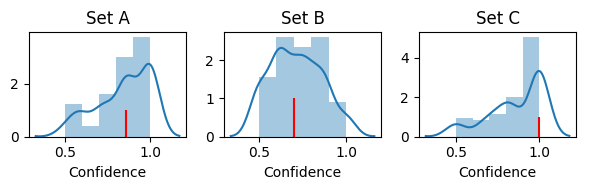

In [153]:
plot_image_distributions(plot_data, subplots=(1,3), figsize=(6,2), histogram=True, bins=5)

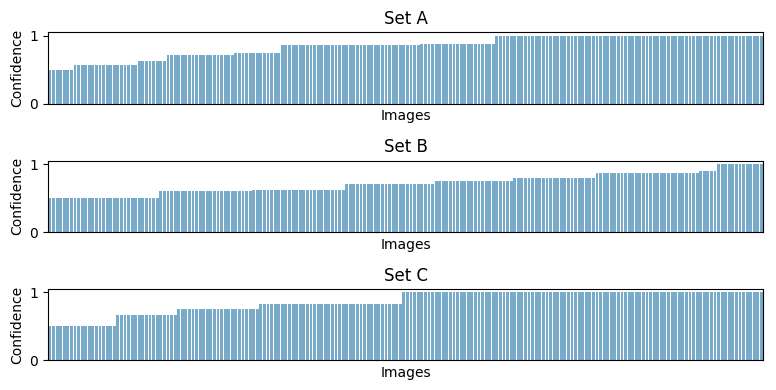

In [49]:
plot_image_distributions(plot_data)

## Plot Stats

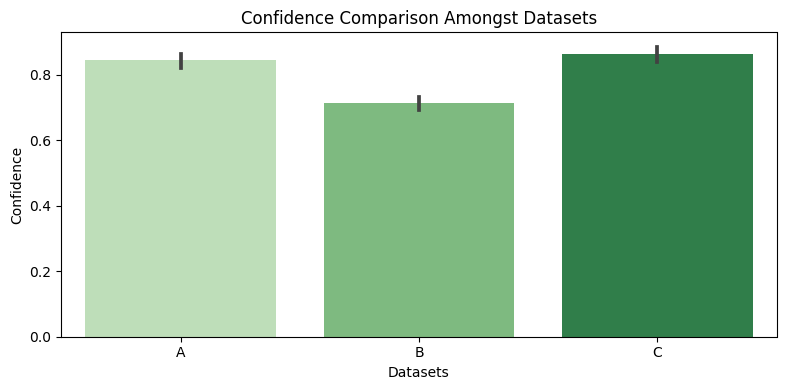

In [50]:
plot_statistics_data(plot_data)

## Filter the Data...

In [51]:
filtered_dataset = {}
max_100s = 50

for dataset, vals in all_image_data.items():
    filtered_dataset[dataset] = []
    count_100s = 0
    for val in vals:
        if val["img_confidence"] == 1.0:
            count_100s += 1
            
            if count_100s > max_100s:
                continue
            
        filtered_dataset[dataset].append(val)


In [52]:
filtered_plot_data, filtered_dataset_statistics = create_plot_data(filtered_dataset)

### Plot FIltered Data

lower_conf_count: 104
higher_conf_count: 71
Set median: 0.857142857143
lower_conf_count: 108
higher_conf_count: 92
Set median: 0.7
lower_conf_count: 99
higher_conf_count: 50
Set median: 0.833333333333


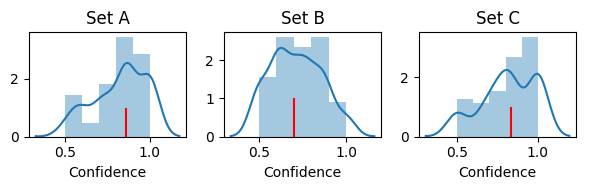

In [152]:
plot_image_distributions(filtered_plot_data, subplots=(1,3), figsize=(6,2), histogram=True, bins=5)

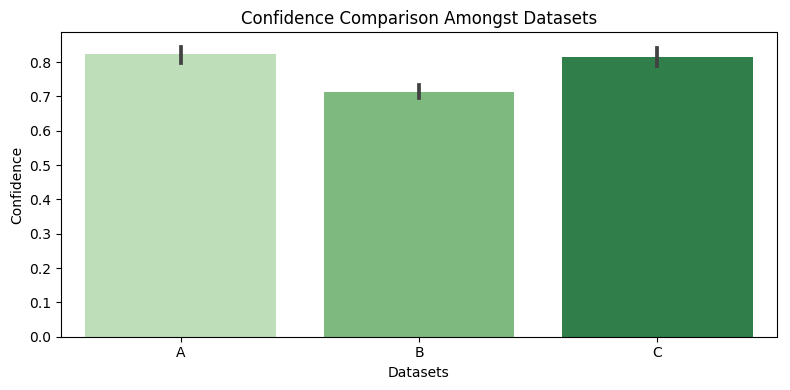

In [54]:
plot_statistics_data(filtered_plot_data)

# Policy Generation

# Policies
 1. Random (basically interspersed)
 2. All low confidence (correctness interspersed)
 3. All high confidence (correctness interspersed)
 4. Low to high confidence
 5. High to low confidence

### High / Low Confidence Determined Empirically
    - Take the median

In [20]:
np.mean([0.857, 0.7, 0.833])

0.7966666666666665

In [21]:
filtered_dataset_statistics

{'A': {'confidence': {'average': 0.8223469387755101,
   'max': 1.0,
   'median': 0.8571428571428571,
   'min': 0.5,
   'std': 0.15391239523209557},
  'correctness': {'average': 0.795,
   'max': 1.0,
   'median': 0.8571428571428571,
   'min': 0.0,
   'std': 0.20142386736437995}},
 'B': {'confidence': {'average': 0.713125,
   'max': 1.0,
   'median': 0.7,
   'min': 0.5,
   'std': 0.1441339979845144},
  'correctness': {'average': 0.648375,
   'max': 1.0,
   'median': 0.7,
   'min': 0.0,
   'std': 0.2101945155683183}},
 'C': {'confidence': {'average': 0.8148769574944071,
   'max': 1.0,
   'median': 0.8333333333333334,
   'min': 0.5,
   'std': 0.16550085485874633},
  'correctness': {'average': 0.7992170022371364,
   'max': 1.0,
   'median': 0.8333333333333334,
   'min': 0.0,
   'std': 0.19237259911986423}}}

### Combine Datasets with Statistics and Set Confidence Thresholds for Each Dataset

In [22]:
for dataset, vals in filtered_dataset.items():
    filtered_dataset[dataset] = {
        "data" : vals,
        "statistics" : filtered_dataset_statistics[dataset],
        "confidence_threshold" : filtered_dataset_statistics[dataset]["confidence"]["median"]
    }

## Get List of Dataset Images for A1, A2, B1, B2, C1, C2

In [23]:
study_1_dataset_images = {key : [] for key in ["A", "B", "C"]}
dataset_breed_keys = {}
dataset_paths = glob2.glob("../../datasets/study_1/*/set*/study/dogs/")
for dataset_path in dataset_paths:

    dataset = dataset_path.split("/")[4].replace("set", "")
    subset = dataset_path.split("/")[5].replace("set", "")
    
    config_file_path = "../../datasets/study_1/set{}/set{}/config".format(dataset, subset)
    
    with open(config_file_path, "r") as infile:
        config_file = infile.readlines()

    breed_key = config_file[0].replace("{", "").replace("}", "")
    breed_key = {breed.split(" : ")[0].strip() : breed.split(" : ")[1].strip() for breed in breed_key.split(",")}
    dataset_breed_keys[subset] = breed_key
    image_list = glob2.glob("{}/*.png".format(dataset_path))
    
    for img_i, img in enumerate(image_list):
        if "dog_A" in img:
            img = img.replace("dog_A", breed_key["dog_A"])
        else:
            img = img.replace("dog_B", breed_key["dog_B"])
        image_list[img_i] = img
        
    study_1_dataset_images[dataset] += image_list
    

In [24]:
study_1_dataset_images

{'A': ['../../datasets/study_1/setA/setA1/study/dogs/basset_hound__169__dr7.png',
  '../../datasets/study_1/setA/setA1/study/dogs/basset_hound__149__dr10.png',
  '../../datasets/study_1/setA/setA1/study/dogs/basset_hound__120__dr7.png',
  '../../datasets/study_1/setA/setA1/study/dogs/saint_bernard__79__dr10.png',
  '../../datasets/study_1/setA/setA1/study/dogs/basset_hound__114__dr5.png',
  '../../datasets/study_1/setA/setA1/study/dogs/saint_bernard__126__dr10.png',
  '../../datasets/study_1/setA/setA1/study/dogs/saint_bernard__91__dr10.png',
  '../../datasets/study_1/setA/setA1/study/dogs/basset_hound__103__dr2.png',
  '../../datasets/study_1/setA/setA1/study/dogs/basset_hound__137__dr2.png',
  '../../datasets/study_1/setA/setA1/study/dogs/saint_bernard__99__dr2.png',
  '../../datasets/study_1/setA/setA1/study/dogs/basset_hound__144__dr10.png',
  '../../datasets/study_1/setA/setA1/study/dogs/basset_hound__114__dr7.png',
  '../../datasets/study_1/setA/setA1/study/dogs/basset_hound__120

### Update Dataset with s1 references

In [25]:
for dataset, vals in filtered_dataset.items():
    for img_i, img in enumerate(vals["data"]):
        img_name = img["img_name"].split("/")[-1]
        study_1_images = study_1_dataset_images[dataset]
        for study_1_img in study_1_images:

            if img_name in study_1_img:
                subset_key = study_1_img.split("/")[5].replace("set", "")
                subset_keys = dataset_breed_keys[subset_key]
                for key, val in subset_keys.items():
                    if val in study_1_img:
                        study_1_img = study_1_img.replace(val, key)
                        study_1_img = study_1_img.split("set{}/".format(dataset))[1]
                        study_1_img = "http:/cu-visualab.org/oracle_query/S2/imgs/{}".format(study_1_img)
                filtered_dataset[dataset]["data"][img_i]["path"] = study_1_img
                filtered_dataset[dataset]["data"][img_i]["secure_path"] = study_1_img.replace("http", "https")
                break

In [26]:
filtered_dataset

{'A': {'confidence_threshold': 0.8571428571428571,
  'data': [{'actual_label': 'basset_hound',
    'img_confidence': 1.0,
    'img_correctness': 1.0,
    'img_name': 'static/imgs/study/dogs/basset_hound__149__dr2.png',
    'majority_label': 'basset_hound',
    'path': 'http:/cu-visualab.org/oracle_query/S2/imgs/setA1/study/dogs/dog_A__149__dr2.png',
    'secure_path': 'https:/cu-visualab.org/oracle_query/S2/imgs/setA1/study/dogs/dog_A__149__dr2.png'},
   {'actual_label': 'saint_bernard',
    'img_confidence': 1.0,
    'img_correctness': 1.0,
    'img_name': 'static/imgs/study/dogs/saint_bernard__99__dr7.png',
    'majority_label': 'saint_bernard',
    'path': 'http:/cu-visualab.org/oracle_query/S2/imgs/setA1/study/dogs/dog_B__99__dr7.png',
    'secure_path': 'https:/cu-visualab.org/oracle_query/S2/imgs/setA1/study/dogs/dog_B__99__dr7.png'},
   {'actual_label': 'saint_bernard',
    'img_confidence': 0.5714285714285714,
    'img_correctness': 0.5714285714285714,
    'img_name': 'static/i

In [27]:
for key in filtered_dataset.keys():
    num_filtered = len(filtered_dataset[key]["data"])
    print("Num {}: {}".format(key, num_filtered))

Num A: 175
Num C: 149
Num B: 200


### Explore Filtered Dataset

In [28]:
get_major_set_confidences = lambda data_set, major_key : [img["img_confidence"] for img in data_set[major_key]["data"]]

def get_set_stats(dataset, major_key):
    the_set = get_major_set_confidences(dataset, major_key)

    the_set_ave = np.mean(the_set)
    the_set_std = np.std(the_set)

    print("Set {} -- Ave: {} -- STD: {}".format(major_key, the_set_ave, the_set_std))

In [29]:
get_set_stats(filtered_dataset, "A")

Set A -- Ave: 0.822346938776 -- STD: 0.153912395232


In [30]:
get_set_stats(filtered_dataset, "B")

Set B -- Ave: 0.713125 -- STD: 0.144133997985


In [31]:
get_set_stats(filtered_dataset, "C")

Set C -- Ave: 0.814876957494 -- STD: 0.165500854859


In [32]:
get_sub_set_confidences = lambda data_set, major_key, minor_key : [img["img_confidence"] for img in data_set[major_key]["data"] if "set{}".format(minor_key) in img["path"]]

def get_sub_set_stats(dataset, major_key, minor_key):
    the_set = get_sub_set_confidences(dataset, major_key, minor_key)

    the_set_ave = np.mean(the_set)
    the_set_std = np.std(the_set)
    num_in_set = len(the_set)

    print("Set {} -- {} Images -- Ave: {} -- STD: {}".format(major_key, num_in_set, the_set_ave, the_set_std))

In [33]:
get_sub_set_stats(filtered_dataset, "A", "A1")

Set A -- 84 Images -- Ave: 0.852678571429 -- STD: 0.161559451


In [34]:
get_sub_set_stats(filtered_dataset, "A", "A2")

Set A -- 91 Images -- Ave: 0.794348508634 -- STD: 0.140815538974


In [35]:
get_sub_set_stats(filtered_dataset, "B", "B1")

Set B -- 100 Images -- Ave: 0.74625 -- STD: 0.151508044341


In [36]:
get_sub_set_stats(filtered_dataset, "B", "B2")

Set B -- 100 Images -- Ave: 0.68 -- STD: 0.128062484749


In [37]:
get_sub_set_stats(filtered_dataset, "C", "C1")

Set C -- 85 Images -- Ave: 0.807843137255 -- STD: 0.147984017758


In [38]:
get_sub_set_stats(filtered_dataset, "C", "C2")

Set C -- 64 Images -- Ave: 0.82421875 -- STD: 0.185824217067


# First Generate Datasets for All Conditions

- Genereate a list of all conditions
- For each condition, we want A1, A2, B1, B2, C1, and C2
- For each of these data subsets (e.g., A1), we want to run 3 participants. 
- For each data subset, we want to generate 


Will look like
- P1
 - V1
   - A1
     - Training Set: 25 images randomly sampled w/o replacement from A1 from Study1
     - Test Set: 25 images randomly sampled w/o replacement from A1 from Study1
     Ensure training set and test set have same distribution
   - A2
   - B1
   - B2
   - C1
   - C2

In [39]:
datasets = ["A1", "A2", "B1", "B2", "C1", "C2"]
visualizations = ["tSNE", "none", "numeric", "bar_chart_1", "bar_chart_2", "scatter_plot_1", "scatter_plot_2"]
policies = ["policy_{}".format(i) for i in range(1, 6)]
policies

['policy_1', 'policy_2', 'policy_3', 'policy_4', 'policy_5']

### Function for retrieving relevant images from subset in sorted dataset

In [40]:
get_relevant_study_1_images = lambda dataset, key, subset : [data for data in dataset[key]["data"] if subset in data["path"]]

### Sort by confidence

In [41]:
def sort_by_confidence(data):
    """
        {
            'majority_label': 'basset_hound', 
            'img_confidence': 1.0, 
            'path': '../../datasets/study_1/setA/setA1/study/dogs/dog_A__149__dr2.png', 
            'img_correctness': 1.0, 
            'img_name': 'static/imgs/study/dogs/basset_hound__149__dr2.png', 
            'actual_label': 'basset_hound'
        }
    """
    dtype=[('a', int), ('b', float)]
    sorted_data = []
    for val_i, val in enumerate(data):
        data_i = (val_i, val["img_confidence"])
        sorted_data.append(data_i)
    
    sorted_data = np.array(sorted_data, dtype=dtype)
    sorted_data = np.sort(sorted_data, order=['b'])
    
    sorted_indices = [data_i[0] for data_i in sorted_data]
    sorted_data = [data[sorted_index] for sorted_index in sorted_indices]
    
    return sorted_data

### Writing the data

In [42]:
def write_policy_data(condition, vis, policy, dataset, data):
    filename = "{}__{}__set{}.json".format(policy, vis, dataset)
    write_path = "condition_data/{}".format(filename)
    with open(write_path, "w") as outfile:
        json.dump(data, outfile)

### Generate lists of images

In [43]:
get_dataset_threshold = lambda imgset : np.median([img_i["img_confidence"] for img_i in imgset])
ALL_DATASETS = {}
condition = 1
for vis in visualizations:
    ALL_DATASETS[vis] = {}
    for policy in policies:
        ALL_DATASETS[vis][policy] = {}
        for dataset in datasets:
            ALL_DATASETS[vis][policy][dataset] = {}
            
            # Load study 1 dataset
            possible_set_images = get_relevant_study_1_images(filtered_dataset, dataset[0], "set{}".format(dataset))
            num_possible_images = len(possible_set_images)
            sample_interval = int(num_possible_images / 25)
            
            # Sort images by confidence
            sorted_possible_set_images = sort_by_confidence(possible_set_images)
            
            # POLICY_1: RANDOM
            if policy == "policy_1":
                np.random.shuffle(sorted_possible_set_images)
                
                sample_with_replacement = True if num_possible_images < 50 else False
                    
                sampled_images = np.random.choice(sorted_possible_set_images, 50, replace=sample_with_replacement)
                
                # Label all sampled images as active

                # Training set
                training_set = sampled_images[:25]
                
                # Testing set
                test_set = sampled_images[25:]
            
            # POLICY_2: All low confidence (correctness interspersed)
            elif policy == "policy_2":
                # Get the dataset confidence threshold
                confidence_threshold = get_dataset_threshold(possible_set_images)
                confidence_threshold = 0.75 if confidence_threshold > 0.75 else confidence_threshold

                thresholded_images = [img for img in sorted_possible_set_images if img["img_confidence"] <= confidence_threshold]
                    
                sample_with_replacement = True if num_possible_images < 50 else False
                num_to_sample = len(thresholded_images)
                sampled_images = np.random.choice(thresholded_images, num_to_sample, replace=sample_with_replacement)
                
                sample_with_replacement = True if len(sampled_images) < 25 else False
                
                # Training set
                training_set = np.random.choice(sampled_images, 25, replace=sample_with_replacement)
                
                # Testing set
                test_set = np.random.choice(sampled_images, 25, replace=sample_with_replacement)
                
            # POLICY_3: All high confidence (correctness interspersed)
            elif policy == "policy_3":
                # Get the dataset confidence threshold
                confidence_threshold = get_dataset_threshold(possible_set_images)
                confidence_threshold = 0.75 if confidence_threshold > 0.75 else confidence_threshold
                
                thresholded_images = [img for img in sorted_possible_set_images if img["img_confidence"] > confidence_threshold+0.025]
                    
                sample_with_replacement = True if num_possible_images < 50 else False
                num_to_sample = len(thresholded_images)
                sampled_images = np.random.choice(thresholded_images, num_to_sample, replace=sample_with_replacement)
                
                sample_with_replacement = True if len(sampled_images) < 25 else False
                
                # Training set
                training_set = np.random.choice(sampled_images, 25, replace=sample_with_replacement)
                
                # Testing set
                test_set = np.random.choice(sampled_images, 25, replace=sample_with_replacement)
            
            # POLICY_4: Low to high confidence
            elif policy == "policy_4":
                np.random.shuffle(sorted_possible_set_images)
                
                sample_with_replacement = True if num_possible_images < 50 else False
                    
                sampled_images = np.random.choice(sorted_possible_set_images, 50, replace=sample_with_replacement)
                # Training set
                training_set = sampled_images[:25]
                training_set = sort_by_confidence(training_set)
                
                # Testing set
                test_set = sampled_images[25:]
                test_set = sort_by_confidence(test_set)
             
            # POLICY_5: High to low confidence
            elif policy == "policy_5":
                np.random.shuffle(sorted_possible_set_images)
                
                sample_with_replacement = True if num_possible_images < 50 else False
                    
                sampled_images = np.random.choice(sorted_possible_set_images, 50, replace=sample_with_replacement)
                # Training set
                training_set = sampled_images[:25]
                training_set = sort_by_confidence(training_set)[::-1]
                
                # Testing set
                test_set = sampled_images[25:]
                test_set = sort_by_confidence(test_set)[::-1]
            
            # Label all images in training and test sets as active
            for train_i, training_img in enumerate(training_set):
                training_img["active"] = True
                training_set[train_i] = training_img
            
            for test_i, test_img in enumerate(test_set):
                test_img["active"] = True
                test_set[test_i] = test_img
                
            # Add other images from opposite subset; i.e., if this set is A1, add images of A2 and label activity as false
            alt_dataset = "{}1".format(dataset[0]) if dataset[1] == "2" else "{}2".format(dataset[0])
            alt_set_images = get_relevant_study_1_images(filtered_dataset, alt_dataset[0], "set{}".format(alt_dataset))
            
            training_set = list(training_set)
            test_set = list(test_set)
            
            for alt_img in alt_set_images:
                alt_img["active"] = False
                training_set.append(alt_img)
                test_set.append(alt_img)
                
#             for cur_set_img in possible_set_images:
#                 cur_set_img["active"] = False
#                 training_set.append(cur_set_img)
#                 test_set.append(cur_set_img)
                
            ALL_DATASETS[vis][policy][dataset]["training"] = training_set
            ALL_DATASETS[vis][policy][dataset]["test"] = test_set
                
            # Write data
            write_policy_data(condition, vis, policy, dataset, ALL_DATASETS[vis][policy][dataset])
            condition += 1


## Check data

In [44]:
ALL_DATASETS["tSNE"]["policy_1"]["B1"]

{'test': [{'active': False,
   'actual_label': 'chihuahua',
   'img_confidence': 0.625,
   'img_correctness': 0.625,
   'img_name': 'static/imgs/study/dogs/chihuahua__34__dr10.png',
   'majority_label': 'chihuahua',
   'path': 'http:/cu-visualab.org/oracle_query/S2/imgs/setB1/study/dogs/dog_A__34__dr10.png',
   'secure_path': 'https:/cu-visualab.org/oracle_query/S2/imgs/setB1/study/dogs/dog_A__34__dr10.png'},
  {'active': False,
   'actual_label': 'chihuahua',
   'img_confidence': 0.625,
   'img_correctness': 0.625,
   'img_name': 'static/imgs/study/dogs/chihuahua__40__dr2.png',
   'majority_label': 'chihuahua',
   'path': 'http:/cu-visualab.org/oracle_query/S2/imgs/setB1/study/dogs/dog_A__40__dr2.png',
   'secure_path': 'https:/cu-visualab.org/oracle_query/S2/imgs/setB1/study/dogs/dog_A__40__dr2.png'},
  {'active': False,
   'actual_label': 'chihuahua',
   'img_confidence': 0.625,
   'img_correctness': 0.375,
   'img_name': 'static/imgs/study/dogs/chihuahua__121__dr7.png',
   'majorit